In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numpy.linalg import inv

In [2]:
#https://www.top1000funds.com/wp-content/uploads/2010/11/FAJskulls.pdf

Create Dataset for SMA function: Pull in Stock Data, Generate Turbulence Indicator

In [81]:
#read in stock data
tickers = ['SPY','TLT','GLD',"GBTC","DIA","JNK","SPSB","SPDW","SPEM","SPAB"] # try to gain information from different markets
start = datetime(2015,7,1)
end = datetime(2021,2,1)
stocks=pd.DataFrame()
stock_div=pd.DataFrame()
for tick in tickers:
    stocks[tick] = data.DataReader(tick, 'yahoo', start, end)["Close"]
    stock_div[tick+' div'] = data.DataReader(tick, 'yahoo-dividends', start, end)["value"]
stocks = pd.concat([stocks,stock_div],axis=1)
stocks = stocks.fillna(0)

#Adding dividends to price appreciation on a daily percent return basis
raw_returns=pd.DataFrame()
for tick in tickers:
    raw_returns[tick] = stocks[tick].pct_change()+stocks[tick+' div']/stocks[tick]
returns=raw_returns[1:]
returns = returns[np.isfinite(returns).all(1)]

#Turbulence indicator- I use the square root because the magnitude of the indicator is higher for daily data
#starts 15 days in for stability reasons. inverse covariance matrix is large and sometimes negative for small sample sizes
turbulence=[]
for i in range(15,len(returns)):
    deviation = returns.iloc[i]-returns[:i].mean() #[:i] prevents information bleed
    inverse = np.linalg.inv(returns[:i].cov())     #[:i] prevents information bleed
    turb = np.sqrt(np.matmul(np.matmul(deviation.T,inverse),deviation))
    turbulence.append(turb)
AllData = returns[15:]
AllData['Turbulence']=turbulence

C:\Users\avid\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Show Data

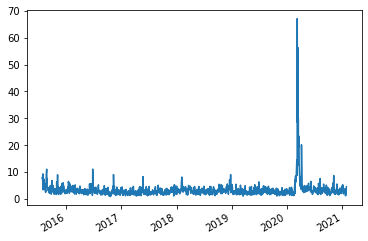

In [82]:
AllData["Turbulence"].plot()

In [83]:
AllData.head()

,SPY,TLT,GLD,GBTC,DIA,JNK,SPSB,SPDW,SPEM,SPAB,Turbulence
2015-07-24,-0.010372,0.002478,0.009777,0.001638,-0.009257,-0.003702,-0.000655,-0.009527,-0.013674,0.000521,7.820398
2015-07-27,-0.005817,0.005355,-0.004651,-0.001635,-0.007350,-0.004246,0.001310,-0.008194,-0.022116,0.001388,7.724158
2015-07-28,0.012283,-0.007293,0.001526,0.001638,0.010790,0.003465,0.000327,0.011853,0.006076,-0.001733,6.847804
2015-07-29,0.006879,-0.003714,0.001428,-0.003274,0.006530,0.006109,-0.000654,0.004615,0.008220,-0.000521,9.261124
2015-07-30,0.000237,0.007705,-0.008558,0.001644,-0.000226,0.002904,0.000000,-0.001060,-0.004825,0.001216,3.391240


SMA Strategy

In [86]:
#Simple moving average strategy with broadly tuned parameters validated on "2015-07-24" to "2017-06-01"
# Buy when asset returns are away from their correlations and returns are positive.
# Sell when turbulence falls and the days returns were negative

def SMA(data,ticker):
    timing = 1
    SMA_len =14
    hold = 'cash'
    acct_value = [1]*(SMA_len+1)
    trades=[]
    count = 0
    
    for n in range (SMA_len, len(data)):
        turb = data['Turbulence'][n]
        SMA = data['Turbulence'][n-SMA_len:n-1].mean()
        
        if ((turb < SMA) & (hold =='stock') & (data[ticker][n]<0)): #the sell signal: dramatic turb increase and SPY fell during the day
            hold ='cash'
            close_position = acct_value[n]
            if close_position > open_position:
                trades.append(1)
                #print(n,'Sell')
            else: 
                trades.append(0)
                #print(n,'Sell')
        
        elif ((turb > 2*SMA) & (hold =='cash')&(data[ticker][n]>0)): #the buy signal
            hold = 'stock'
            open_position = acct_value[n]
            timing = acct_value[n]*(data[ticker][n]+1)
            #print(n, 'Buy')
            count+=1
        
        elif (hold =='stock'): #holding
            timing = acct_value[n]*(data[ticker][n]+1)
            count+=1
        
        if n != (len(data)-1):
            acct_value.append(timing)
            
    return(timing, acct_value, trades,count)

In [118]:
final_val, daily_val, trades, count = SMA(AllData,'SPY')
print('Includes validation data')
print('Final Account value = ', final_val)
print('Percent of trades that made money = ', np.count_nonzero(trades)/len(trades))
print( 'Number of days in the market = ', count)

Includes validation data
Final Account value =  1.2628102721628818
Percent of trades that made money =  0.9333333333333333
Number of days in the market =  96


In [89]:
#indexes to drop / represents Validation set. Done manually to avoid error due to weekends 
print(AllData.index.get_loc("2015-07-24"), AllData.index.get_loc("2017-06-01"))

0 467


In [90]:
#data manipulations to get to a dataframe with account returns included and with dates matching up
AllData['daily_val'] = pd.DataFrame(daily_val).set_index(AllData.index)
AllData['acct_returns'] = AllData['daily_val'].pct_change()

#subtract out training set and those lost due to the initial SMA length where the strategy won't trade
out_of_sample = AllData.drop(AllData.index[0:467+15])

C:\Users\avid\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\avid\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
out_of_sample

,SPY,TLT,GLD,GBTC,DIA,JNK,SPSB,SPDW,SPEM,SPAB,Turbulence,daily_val,acct_returns
2017-06-22,-0.000453,0.002195,0.003375,-0.024977,-0.000748,0.002441,0.000326,0.002763,0.003478,0.001036,1.143770,1.067298,0.0
2017-06-23,0.001194,-0.000469,0.004289,0.033398,0.000047,0.003788,0.000000,0.002067,0.003165,-0.001552,2.295803,1.067298,0.0
2017-06-26,0.000658,0.003756,-0.008959,-0.106092,0.000608,0.001348,0.000000,0.001031,0.010365,0.002418,3.651595,1.067298,0.0
2017-06-27,-0.008056,-0.010681,0.003802,0.012634,-0.004395,-0.002423,0.000000,0.000343,-0.013381,-0.003101,3.770333,1.067298,0.0
2017-06-28,0.008950,-0.003310,0.000758,0.038437,0.006152,0.003508,0.000326,0.008239,0.010850,0.000173,1.994196,1.067298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26,-0.001561,-0.001887,-0.002471,-0.047292,-0.000840,-0.000551,0.000000,0.000000,-0.003746,-0.000326,1.125400,1.262810,0.0
2021-01-27,-0.024440,0.002543,-0.006336,-0.004002,-0.019813,-0.003123,-0.000319,-0.024341,-0.025437,0.000327,3.747018,1.262810,0.0
2021-01-28,0.008600,-0.005528,0.000927,0.072829,0.009266,0.002672,0.000637,0.008512,0.006128,-0.000979,1.436661,1.262810,0.0
2021-01-29,-0.020020,-0.006016,-0.000405,0.031060,-0.020453,-0.003951,0.000000,-0.022119,-0.023235,-0.001307,3.120964,1.262810,0.0


In [92]:
#get price data from SPY and account returns
hold = [1]
turb_strat = [1]
tick = 'SPY'
for n in range(1,len(out_of_sample)):
#    if n == 0:
#        hold.append(1 * (out_of_sample[tick].iloc[n]+1))
#        turb_strat.append(1 * (out_of_sample['acct_returns'].iloc[n]+1))
        
    hold.append(hold[n-1] * (out_of_sample[tick][n]+1))
    turb_strat.append(turb_strat[n-1] * (out_of_sample['acct_returns'][n]+1))

#hold = pd.DataFrame(hold)[:-1].set_index(validation.index)
#turb_strat = pd.DataFrame(turb_strat)[:-1].set_index(validation.index)

strats = pd.DataFrame(hold).set_index(out_of_sample.index).rename(columns={0: "hold"})
strats['turb_strat'] = pd.DataFrame(turb_strat).set_index(out_of_sample.index)

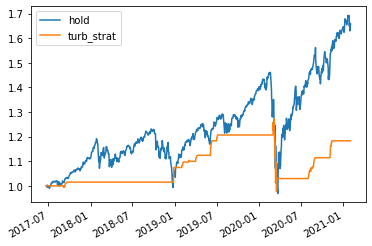

In [94]:
strats.plot()

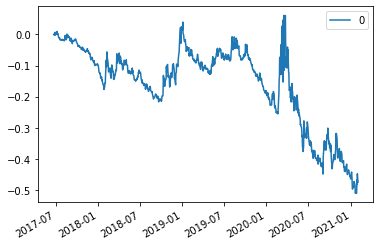

In [95]:
#relative performance
pd.DataFrame(strats['turb_strat']-strats['hold']).plot()

In [108]:
#average of monthly returns for each strategy
strats.pct_change().resample("M").apply(lambda x: ((x + 1).cumprod() - 1).last("D")).mean()

hold          0.012439
turb_strat    0.004198
dtype: float64

In [109]:
#std deviation of monthly returns
strats.pct_change().resample("M").apply(lambda x: ((x + 1).cumprod() - 1).last("D")).std()

hold          0.048378
turb_strat    0.029781
dtype: float64

In [ ]:
# Takeaway: with parameters of the SMA only broadly tuned tuned to "2015-07-24" to "2017-06-01",the strategy was blown 
# out of the water when it reached March 2020. I was hoping it would catch the huge increase that come after 
# massive declines but I suspect that the 14 day turbulence SMA rose too much and the turbulance signal 
# fell too quickly prompting the sell signal and so the strategy missed out on the massive rally.


# Next steps: compare turbulance to Vix sma strategy.
# consider combining this tail risk hedging strategy with a buy and hold strategy to std of returns and cumulative returns
# Gaining access to higher frequency data could improve the efficacy of this strategy